# Wasserstein mapping network to paint halos from 3D dark matter fields



**Please cite the paper below if you make use of the code:**  
"*Painting halos from 3D dark matter fields using Wasserstein mapping networks*," Doogesh Kodi Ramanah, Tom Charnock, Guilhem Lavaux, [arXiv link](https://arxiv.org/abs/1903.10524)

We employ a novel halo painting network that learns to map approximate 3D dark matter fields to realistic halo distributions. We construct a physical mapping network, inspired by a recently proposed variant of generative models, known as generative adversarial networks (GANs). In particular, we will use the key ideas in training WGANs, i.e. GANs optimized using the Wasserstein distance, to ensure that our network is able to paint halos well.

In our Wasserstein mapping framework, as depicted below, our generator is the halo painting network whose role is to learn the underlying non-linear relationship between the input 3D density field and the corresponding halo count distribution. Our critic provides as output the approximately learnt Wasserstein distance between the real and predicted halo distributions. This approximate Wasserstein distance is the loss function that must be minimized to train the halo painting network.

<img src="WGN_schematic.jpg" alt="Drawing" style="width: 1250px;"/>

### Import relevant packages

In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
import tqdm
import scipy as sp

Populating the interactive namespace from numpy and matplotlib


### Load 2LPT density and halo fields (fiducial cosmology)

The data comes from the VELMASS simulations, where the halos are found using ROCKSTAR. The data is not explicitly provided here. For training we use the second set of initialisation phases at the central cosmology so that training and validation sets are independent.

In [2]:
resolution = 512
density = np.load('../data_LPT_512_central2/density_central_2_lpt_512.npy')
density = density.astype(np.float32)
density = density.reshape((resolution, resolution, resolution))
halo = np.load('../data_LPT_512_central2/halo_central_2_512_combined.npy')
halo = halo.astype(np.float32).reshape((resolution, resolution, resolution))

### Normalize 2LPT density such that mean density guaranteed to be unity

In [3]:
density /= density.sum()/resolution**3

### Visualize training set (a given _thick_ slice of input 2LPT density and reference halo fields)

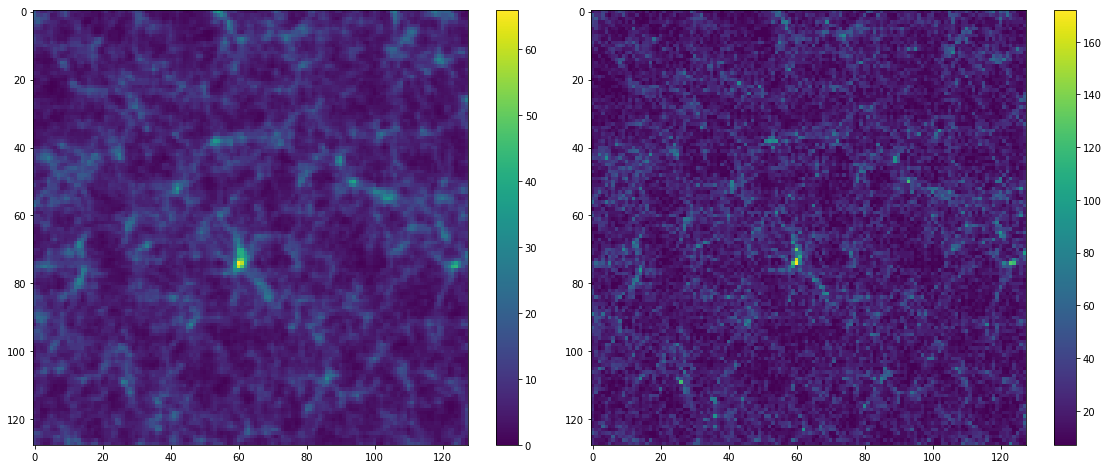

In [4]:
fig, ax = subplots(1, 2, figsize = (20, 8))
subplots_adjust(wspace = 0, hspace = 0.1)
ax0 = ax[1].imshow(np.sum(halo[:128,:128, :25],axis=2)); colorbar(ax0, ax=ax[0]);
ax1 = ax[0].imshow(np.sum(density[:128,:128, :25], axis=2)); colorbar(ax1, ax=ax[1]);

## Set up the TensorFlow graph

### Data augmentation
We are going to perform data-augmentation on the fly to save time. In particular we will perform right angle rotations, with a total of 24 possibilities, to randomly selected 3D slices of training set.

In [5]:
def rotations(x, rand):

    return tf.case(
        {tf.equal(rand, 1): lambda: x[:, ::-1, ::-1, :, :],
         tf.equal(rand, 2): lambda: x[:, ::-1, :, ::-1, :],
         tf.equal(rand, 3): lambda: x[:, :, ::-1, ::-1, :],
         tf.equal(rand, 4): lambda: tf.transpose(x, (0, 2, 1, 3, 4))[:, ::-1, :, :, :],
         tf.equal(rand, 5): lambda: tf.transpose(x, (0, 2, 1, 3, 4))[:, ::-1, :, ::-1, :],
         tf.equal(rand, 6): lambda: tf.transpose(x, (0, 2, 1, 3, 4))[:, :, ::-1, :, :],
         tf.equal(rand, 7): lambda: tf.transpose(x, (0, 2, 1, 3, 4))[:, :, ::-1, ::-1, :],
         tf.equal(rand, 8): lambda: tf.transpose(x, (0, 3, 2, 1, 4))[:, ::-1, :, :, :],
         tf.equal(rand, 9): lambda: tf.transpose(x, (0, 3, 2, 1, 4))[:, ::-1, ::-1, :, :],
         tf.equal(rand, 10): lambda: tf.transpose(x, (0, 3, 2, 1, 4))[:, :, :, ::-1, :],
         tf.equal(rand, 11): lambda: tf.transpose(x, (0, 3, 2, 1, 4))[:, :, ::-1, ::-1, :],
         tf.equal(rand, 12): lambda: tf.transpose(x, (0, 1, 3, 2, 4))[:, :, ::-1, :, :],
         tf.equal(rand, 13): lambda: tf.transpose(x, (0, 1, 3, 2, 4))[:, ::-1, ::-1, :, :],
         tf.equal(rand, 14): lambda: tf.transpose(x, (0, 1, 3, 2, 4))[:, :, :, ::-1, :],
         tf.equal(rand, 15): lambda: tf.transpose(x, (0, 1, 3, 2, 4))[:, ::-1, :, ::-1, :],
         tf.equal(rand, 16): lambda: tf.transpose(x, (0, 2, 3, 1, 4))[:, ::-1, ::-1, :, :],
         tf.equal(rand, 17): lambda: tf.transpose(x, (0, 2, 3, 1, 4))[:, :, ::-1, ::-1, :],
         tf.equal(rand, 18): lambda: tf.transpose(x, (0, 2, 3, 1, 4))[:, ::-1, :, ::-1, :],
         tf.equal(rand, 19): lambda: tf.transpose(x, (0, 2, 3, 1, 4))[:, ::-1, ::-1, ::-1, :], 
         tf.equal(rand, 20): lambda: tf.transpose(x, (0, 3, 1, 2, 4))[:, ::-1, ::-1, :, :],
         tf.equal(rand, 21): lambda: tf.transpose(x, (0, 3, 1, 2, 4))[:, ::-1, :, ::-1, :],
         tf.equal(rand, 22): lambda: tf.transpose(x, (0, 3, 1, 2, 4))[:, :, ::-1, ::-1, :],
         tf.equal(rand, 23): lambda: tf.transpose(x, (0, 3, 1, 2, 4))[:, ::-1, ::-1, ::-1, :],
         tf.equal(rand, 24): lambda: x}, default = lambda: x, exclusive = True)

### Construct the critic network
The critic encodes a series of four convolutional layers, with a gradual reduction in their kernel sizes from 7x7x7 to 1x1x1, activated with $\texttt{leaky ReLU}$. The output of the final convolutional layer is flattened and fed into a fully connected layer with linear activation.
Essentially, the critic reduces the input real and generated 3D halo fields to a compact representation whose difference is an approximation to the Wasserstein distance.

In [7]:
def W(data):

    w1 = tf.get_variable("W_w1", 
                         (7, 7, 7, 1, 8), 
                         dtype=tf.float32, 
                         initializer=tf.random_normal_initializer(0, 0.1))
    b1 = tf.get_variable("W_b1", 
                         (8), 
                         dtype=tf.float32, 
                         initializer=tf.constant_initializer(0.1))
    x1 = tf.nn.leaky_relu(tf.nn.conv3d(data, 
                                       w1, 
                                       strides=[1, 2, 2, 2, 1], 
                                       padding='VALID') + b1,0.1)

    w2 = tf.get_variable("W_w2",
                         (5, 5, 5, 8, 16),
                         dtype=tf.float32,
                         initializer=tf.random_normal_initializer(0, 0.1))
    b2 = tf.get_variable("W_b2",
                         (16),
                         dtype=tf.float32,
                         initializer=tf.constant_initializer(0.1))
    x2 = tf.nn.leaky_relu(tf.nn.conv3d(x1, 
                                       w2, 
                                       strides=[1, 1, 1, 1, 1], 
                                       padding='VALID') + b2, 0.1)
    
    w3 = tf.get_variable("W_w3",
                         (3, 3, 3, 16, 32),
                         dtype=tf.float32,
                         initializer=tf.random_normal_initializer(0, 0.1))
    b3 = tf.get_variable("W_b3",
                         (32),
                         dtype=tf.float32,
                         initializer=tf.constant_initializer(0.1))
    x3 = tf.nn.leaky_relu(tf.nn.conv3d(x2, 
                                       w3, 
                                       strides=[1, 2, 2, 2, 1], 
                                       padding='VALID') + b3, 0.1)
    
    w4 = tf.get_variable("W_w4",
                         (1, 1, 1, 32, 64),
                         dtype=tf.float32,
                         initializer=tf.random_normal_initializer(0, 0.1))
    b4 = tf.get_variable("W_b4",
                         (64),
                         dtype=tf.float32,
                         initializer=tf.constant_initializer(0.1))
    x4 = tf.nn.leaky_relu(tf.nn.conv3d(x3, 
                                       w4, 
                                       strides=[1, 1, 1, 1, 1], 
                                       padding='VALID') + b4, 0.1)    
        
    x5 = tf.reshape(x4, (-1, np.product(x4.get_shape().as_list()[1:])))
    w5 = tf.get_variable("W_w5", 
                         (x5.get_shape().as_list()[-1], 1), 
                         dtype=tf.float32, 
                         initializer=tf.random_normal_initializer(0, 0.1))
    b5 = tf.get_variable("W_b5", 
                         (1), 
                         dtype=tf.float32, 
                         initializer=tf.constant_initializer(0.1))
    x_out = tf.matmul(x5, w5) + b5
    
    return x_out

### Residual inception module
We employ Inception blocks, encoding residual connections in a modified variant of the originally proposed Inception module, in the architecture of our generator network, as illustrated below.

<img src="residual_inception_schematic.jpg" alt="Drawing" style="width: 500px;"/>

In [8]:
def inception(x, filters_1x1x1_5x5x5, filters_5x5x5, filters_1x1x1_3x3x3, filters_3x3x3, filters_1x1x1, name):
    
    input_filters = x.get_shape().as_list()[-1]
    
    w_1x1x1_5x5x5 = tf.get_variable(name + "_w_1x1x1_5x5x5", 
                                    (1, 1, 1, input_filters, filters_1x1x1_5x5x5),
                                    dtype=tf.float32,
                                    initializer=tf.random_normal_initializer(0, 0.1))
    b_1x1x1_5x5x5 = tf.get_variable(name + "_b_1x1x1_5x5x5", 
                                    (filters_1x1x1_5x5x5),
                                    dtype=tf.float32,
                                    initializer=tf.constant_initializer(0.1))
    x_1x1x1_5x5x5 = tf.nn.conv3d(x, 
                                 w_1x1x1_5x5x5, 
                                 strides=[1, 1, 1, 1, 1], 
                                 padding='VALID') + b_1x1x1_5x5x5
    w_5x5x5 = tf.get_variable(name + "_w_5x5x5", 
                              (5, 5, 5, filters_1x1x1_5x5x5, filters_5x5x5),
                              dtype=tf.float32,
                              initializer=tf.random_normal_initializer(0, 0.1))
    b_5x5x5 = tf.get_variable(name + "_b_5x5x5", 
                              (filters_5x5x5),
                              dtype=tf.float32, 
                              initializer=tf.constant_initializer(0.1))
    x_5x5x5 = tf.nn.conv3d(x_1x1x1_5x5x5, 
                           w_5x5x5, 
                           strides=[1, 1, 1, 1, 1], 
                           padding='VALID') + b_5x5x5
    w_1x1x1_3x3x3 = tf.get_variable(name + "_w_1x1x1_3x3x3", 
                                    (1, 1, 1, input_filters, filters_1x1x1_3x3x3), 
                                    dtype=tf.float32, 
                                    initializer=tf.random_normal_initializer(0, 0.1))
    b_1x1x1_3x3x3 = tf.get_variable(name + "_b_1x1x1_3x3x3", 
                                    (filters_1x1x1_3x3x3),
                                    dtype=tf.float32, 
                                    initializer=tf.constant_initializer(0.1))
    x_1x1x1_3x3x3 = tf.nn.conv3d(x, 
                                 w_1x1x1_3x3x3, 
                                 strides=[1, 1, 1, 1, 1], 
                                 padding='VALID') + b_1x1x1_3x3x3
    w_3x3x3 = tf.get_variable(name + "_w_3x3x3", 
                              (3, 3, 3, filters_1x1x1_3x3x3, filters_3x3x3), 
                              dtype=tf.float32, 
                              initializer=tf.random_normal_initializer(0, 0.1))
    b_3x3x3 = tf.get_variable(name + "_b_3x3x3", 
                              (filters_3x3x3), 
                              dtype=tf.float32, 
                              initializer=tf.constant_initializer(0.1))
    x_3x3x3 = tf.nn.conv3d(x_1x1x1_3x3x3, 
                           w_3x3x3, 
                           strides=[1, 1, 1, 1, 1], 
                           padding='VALID') + b_3x3x3
    x_3x3x3 = tf.slice(x_3x3x3, 
                       [0, 1, 1, 1, 0], 
                       [-1, 
                        x_5x5x5.get_shape().as_list()[1], 
                        x_5x5x5.get_shape().as_list()[2], 
                        x_5x5x5.get_shape().as_list()[3], 
                        -1])
    w_1x1x1 = tf.get_variable(name + "_w_1x1x1", 
                              (1, 1, 1, input_filters, filters_1x1x1), 
                              dtype=tf.float32, 
                              initializer=tf.random_normal_initializer(0, 0.1))
    b_1x1x1 = tf.get_variable(name + "_b_1x1x1", 
                              (filters_1x1x1), 
                              dtype=tf.float32, 
                              initializer=tf.constant_initializer(0.1))
    x_1x1x1 = tf.nn.conv3d(x, 
                           w_1x1x1, 
                           strides=[1, 1, 1, 1, 1], 
                           padding='SAME') + b_1x1x1
    x_1x1x1 = tf.slice(x_1x1x1, 
                       [0, 2, 2, 2, 0], 
                       [-1,
                        x_5x5x5.get_shape().as_list()[1],
                        x_5x5x5.get_shape().as_list()[2],
                        x_5x5x5.get_shape().as_list()[3],
                        -1])

    x_out = tf.concat((x_5x5x5, x_3x3x3, x_1x1x1), axis=4)
    output_filters = x_out.get_shape().as_list()[-1]

    x_out_ = tf.slice(
        tf.transpose(
            tf.stack([x[:, :, :, :, 0] for i in range(output_filters)]),
            perm=[1, 2, 3, 4, 0]), 
        [0, 2, 2, 2, 0], 
        [-1, 
         tf.shape(x_5x5x5)[1],
         tf.shape(x_5x5x5)[2],
         tf.shape(x_5x5x5)[3],
         -1])
    
    return tf.add(x_out, x_out_)

As well as the inception module we will use 1x1x1 convolutional kernels to increase network depth, but prevent further distribution of information

In [9]:
def kernel_1x1x1_convolutions(x_in, filters_1x1x1, name):
    input_filters = x_in.get_shape().as_list()[-1]
        
    w_1x1x1 = tf.get_variable(name + "_w_1x1x1",
                              (1, 1, 1, input_filters, filters_1x1x1),
                              dtype=tf.float32,
                              initializer=tf.random_normal_initializer(0, 0.1))
    b_1x1x1 = tf.get_variable(name + "_b_1x1x1",
                              (filters_1x1x1),
                              dtype=tf.float32,
                              initializer=tf.constant_initializer(0.1))
    x_1x1x1 = tf.nn.conv3d(x_in, w_1x1x1, strides = [1, 1, 1, 1, 1], padding='SAME') + b_1x1x1
    
    return x_1x1x1

### Construct the generator network
We know that the relationship between the dark matter and halo field is relatively local and non-linear, and we want our network to learn this underlying physical mapping. Our generator takes as input a density field cube and evolves the features forward to yield the corresponding halo count distribution.

The residual Inception blocks propagates the information from fairly local regions of the dark matter field, and since we use residual connections in the Inception blocks, we combine structure from distant patches, whilst still retaining a close relation to the density field itself. The subsequent 1x1x1 convolutions with no residual connections provide the non-linearity to combine the local density distribution and perform the map to the halo distribution. Since there is an enormous complexity in the 2LPT field, we use many filters in each layer to learn the wide variety of possible features. The non-linearity is provided by the $\texttt{leaky ReLU}$ with a leaky parameter of $\alpha=0.1$. To ensure the positivity of the halo count field, we use $\texttt{ReLU}$ at the last layer.

In [10]:
def G(δ, num_convs, n_layers=4):
    x1 = tf.nn.leaky_relu(inception(δ, 10, 10, 10, 10, 10, 'layer_1'), 0.1)
    for i in range(2, num_convs + 2):
        x1 = tf.nn.leaky_relu(inception(x1, 10, 10, 10, 10, 10, 'layer_'+str(i)), 0.1)

    for i in range(n_layers):
        x1 = tf.nn.leaky_relu(kernel_1x1x1_convolutions(x1, 10, 'layer_'+str(i+num_convs+3)), 0.1)

    x_out = tf.nn.relu(kernel_1x1x1_convolutions(x1, 1, 'layer_out'))
    
    return x_out

### Training methodology

We choose the input to the generator to be conveniently larger to eliminate the need for padding. We therefore compute the corresponding sizes of the tensors, which depends on the number of convolutional layers and the desired size of the prediction (in our case, $50^3$).

In [11]:
num_convs = 1
pad = int(((num_convs + 1) * 4) / 2)
input_patch = 50
slice_size = int(input_patch + 2*pad)

During training, we load both the entire 2LPT density field and histogrammed halo count distribution from the simulation into the TensorFlow graph and select by index sub-volume elements of size 58$^3$ and 50$^3$, respectively, which massively reduces computation time compared with passing the 3D slices of data at each weight update.

In [12]:
δ_init = tf.placeholder(dtype=tf.float32, 
                        shape=(resolution, resolution, resolution), 
                        name="initialise_density")
δ = tf.Variable(δ_init, trainable=False, name="density")
δ_assign = tf.assign(δ, δ_init)
h_init = tf.placeholder(dtype=tf.float32, 
                        shape=(resolution, resolution, resolution), 
                        name="initialise_halo")
h = tf.Variable(h_init, trainable=False, name="halo")
h_assign = tf.assign(h, h_init)

We will use a batchsize of 1 since the number of features in a $50^3$ patch is already large, considering we are optimising the map of $9^3$ voxels to a single voxel.

In [13]:
m = 1

We are going to feed into the network a random number for the rotation of the box, a set of x, y and z indices to grab the first element of the slice from the field. We also need a random number $\epsilon=[0, 1]$ for the probability of the halos during the gradient penalty, and finally a number for the strength of the coupling of the gradient penalty.

In [14]:
rotation = tf.placeholder(dtype=tf.int32, shape=(), name="rotation")
ind = tf.placeholder(dtype=tf.int32, shape=(m, 3), name="ind")
ϵ = tf.placeholder(dtype=tf.float32, shape=(m), name="epsilon")
ϵ_ = tf.expand_dims(tf.expand_dims(ϵ, 1), 1)
λ = tf.placeholder(dtype=tf.float32, shape=(), name="lambda")

To be able to pass a cube to the graph, we will make another placeholder for passing densities.

In [15]:
single_δ = tf.placeholder(dtype=tf.float32, 
                          shape=(1, slice_size, slice_size, slice_size, 1),
                          name="single_delta")

While we train on smaller boxes, we eventually verify the network's performance on an unseen simulation (*test set*), where we use predict simulations larger than the ones used to trained the network

In [16]:
big_size = 256
big_slice_size = int(big_size+2*pad)

big_δ = tf.placeholder(dtype=tf.float32, 
                       shape=(1, big_slice_size, big_slice_size, big_slice_size, 1),
                       name="big_delta")

The densities, and halos, stored in the graph are then sliced using the fed indices and `m` batches are concatenated if we wanted to increase the batch size. These tensors are then rotated (the same way for both the density and the halos) as data augmentation.

In [17]:
real_δ = tf.stack([
    tf.reshape(
        tf.slice(δ, 
                 [ind[i][0] - pad, ind[i][1] - pad, ind[i][2] - pad],
                 [slice_size, slice_size, slice_size]),
        (slice_size, slice_size, slice_size, 1)) for i in range(m)],
    name="real_delta")
real_h = tf.stack([
    tf.reshape(
        tf.slice(h, 
                 [ind[i][0], ind[i][1], ind[i][2]], 
                 [input_patch, input_patch, input_patch]), 
        (input_patch, input_patch, input_patch, 1)) for i in range(m)], 
    name="real_h")

δ_rotated = rotations(real_δ, rotation)
h_rotated = rotations(real_h, rotation)

### Computing the approximate Wasserstein distance

The output of the critic is a single scalar which is used to compute the approximately learned Wasserstein distance between the predicted and true halo distributions given a particular generative network. This output can therefore be used to compute the loss function which is minimized to train the generative network. 

First we need the critic result of the real halo.

In [18]:
with tf.variable_scope("W") as scope:
    W_real = tf.identity(W(h_rotated), name="W_real")

And then we want the output of the mapping network (and we will also create another input to the graph provided by the fed density). We also need to grab the result of the critic from this generated output from the mapping network.

In [19]:
with tf.variable_scope("G_com") as scope:
    generated_h = tf.identity(G(δ_rotated, num_convs), name="generated_h")
    scope.reuse_variables()
    output = tf.identity(G(single_δ, num_convs), name="output")
    scope.reuse_variables()
    big_output = tf.identity(G(big_δ, num_convs), name="big_output")    

with tf.variable_scope("G_com") as scope:
    scope.reuse_variables()
    big_output = tf.identity(G(big_δ, num_convs), name="big_output")    
    
with tf.variable_scope("W") as scope:
    scope.reuse_variables()
    W_gen = tf.identity(W(generated_h), name="W_gen")    

For improved training performance, we implement the gradient penalty method via the addition of a penalty term in the critic loss, as an alternative to the standard weight clipping, to enforce the Lipschitz-1 constraint on the critic. This is a requirement for computing the approximate Wasserstein distance. The Lipschitz constraint is enforced by penalizing the gradient norm for random samples $\hat{\mathbf{x}} \sim \mathbb{P}_{\hat{\mathbf{x}}}$, where $\hat{\mathbf{x}} = \epsilon \mathbf{x} + (1 - \epsilon) \tilde{\mathbf{x}}$ and $\epsilon$ is sampled randomly and uniformly, $\epsilon \in [0,1]$.

We calculate this set of random samples, pass it through the critic and then calculate the outputs gradient with respect to the input.

In [20]:
hat_h = ϵ_ * h_rotated + (1. - ϵ_) * generated_h

with tf.variable_scope("W") as scope:
    scope.reuse_variables()
    W_hat = tf.identity(W(hat_h), name="W_hat")
    
W_grad = tf.gradients(W_hat, hat_h, name="W_grad")

The loss function for the critic and the mapping network can now be defined. We define a critic loss with the gradient penalty to be optimised, and a pure measure of the Wasserstein distance for tracking the distance. The mapping network loss does not need the gradient penalty.

In [21]:
W_loss = W_gen - W_real
W_loss_g = tf.reduce_mean(W_loss + λ * (tf.norm(W_grad) - 1.)**2.)
W_loss_n = tf.identity(-tf.reduce_mean(W_loss), name="W_loss_n")
G_loss = tf.reduce_mean(- W_loss, name="G_loss")

### Use the Adam optimizer to train the halo painting and critic networks
Standard choice of hyperparameters for the Adam optimizer.

Since we want to only update the weights of the critic for the critic update and only update the weights of the mapping network for the update of the mapping network, we cycle through the gradient calculations and remove the superfluous weight update operations from the list of operations to be given to the optimizer.

In [22]:
α = 1e-4
β1 = 0.5
β2 = 0.999
W_opt = tf.train.AdamOptimizer(α, β1, β2)
W_grad = W_opt.compute_gradients(W_loss_g)
W_grad_ = []
for i in W_grad:
    if "W" in i[1].name:
        W_grad_.append(i)
W_train = W_opt.apply_gradients(W_grad_, name="W_train")
        
G_opt = tf.train.AdamOptimizer(α, β1, β2)
G_grad = G_opt.compute_gradients(G_loss)
G_grad_ = []
for i in G_grad:
    if "G" in i[1].name:
        G_grad_.append(i)
G_train = G_opt.apply_gradients(G_grad_, name="G_train")

#### Create a session to launch the graph 

Here we feed in the 2LTP and halo fields to be stored in the graph so that they don't have to be passed during training.

In [23]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer(), 
         feed_dict={"initialise_density:0": density, 
                    "initialise_halo:0": halo})

### Pre-training preparations
We choose a standard value for the arbitrary penalty coefficient, which has been shown to work well for a range of network architectures and data sets, and update the weights of the critic five times per single generator update.

In [25]:
λ_value = 10.
n_critic = 5
epochs = 10000 #500000
W_loss_training = []
G_loss_training = []
W_loss_validation = []
G_loss_validation = []
saver = tf.train.Saver()

### Training routine
The training proceeds for a set number of weight updates, until an overall convergence of the generator is achieved. The training rationale is to reduce the Wasserstein distance between the true halo counts and the halo counts mapped from the corresponding input density field such that the generator learns the correct mapping.

The training steps are as follows:
- The input to the generator is randomly chosen and the corresponding true halo counts volume is selected;
- To encode some further symmetries through our training set, we also perform a rotation of the selected patches, thereby extracting the input 3D slice from a randomly oriented region;
- The initial training step involves the optimization of the weights of the critic network to minimize the augmented loss function (including the gradient penalty), while concurrently freezing the parameters of the generator;
- The weights of the critic must be updated $n_{\mathrm{critic}}$ times, where $n_\mathrm{critic}$ is sufficient for the critic to converge;
- In the subsequent step, the critic weights are temporarily anchored, and the generator parameters are adjusted;
- The generator employs the gradient of the Wasserstein loss function w.r.t its parameters for training;
- The training routine then proceeds in iterative fashion, until an overall convergence of the generator is achieved.

We use a $512^3$ simulation box for training, where we use a large portion of the box for training and the remaining section for validation, such that we utilize non-mutual parts of the box for the training and validation set. Note that here, the batch size is unity, such that the number of weight updates corresponds to the number of density field patches used to train the generator.

In [26]:
tq = tqdm.trange(epochs, leave = True, desc = "Epochs")
for e in tq:
    for t in range(n_critic):
        i = int(np.random.randint(0, 25, 1))
        ind_value_1 = np.random.randint(pad, resolution - (slice_size - pad), m)
        ind_value_2 = np.random.randint(pad, resolution - (slice_size - pad), m)
        ind_value_3 = np.random.randint(pad, resolution - slice_size - (slice_size - pad), m)
        ind_value = np.array([ind_value_1, ind_value_2, ind_value_3]).swapaxes(0, 1)
        ϵ_value = np.random.uniform(0, 1, m)
        sess.run("W_train",
                 feed_dict={"ind:0": ind_value, 
                            "epsilon:0": ϵ_value, 
                            "lambda:0": λ_value, 
                            "rotation:0": i})

    # W training loss
    i = int(np.random.randint(0, 25, 1))
    ind_value_1 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_2 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_3 = np.random.randint(pad, resolution - slice_size - (slice_size - pad), m)
    ind_value = np.array([ind_value_1, ind_value_2, ind_value_3]).swapaxes(0, 1)
    ϵ_value = np.random.uniform(0, 1, m)
    W_loss_training.append(sess.run("W_loss_n:0", 
                                    feed_dict={"ind:0": ind_value, 
                                               "epsilon:0": ϵ_value, 
                                               "lambda:0": λ_value, 
                                               "rotation:0": i}))
   
    # W validation loss
    i = int(np.random.randint(0, 25, 1))
    ind_value_1 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_2 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_3 = np.array([resolution - (slice_size - pad) for i in range(m)])
    ind_value = np.array([ind_value_1, ind_value_2, ind_value_3]).swapaxes(0, 1)
    ϵ_value = np.random.uniform(0, 1, m)   
    W_loss_validation.append(sess.run("W_loss_n:0", 
                                      feed_dict={"ind:0": ind_value, 
                                                 "epsilon:0": ϵ_value, 
                                                 "lambda:0": λ_value, 
                                                 "rotation:0": i}))

    # G training loss
    i = int(np.random.randint(0, 25, 1))
    ind_value_1 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_2 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_3 = np.random.randint(pad, resolution - slice_size - (slice_size - pad), m)
    ind_value = np.array([ind_value_1, ind_value_2, ind_value_3]).swapaxes(0, 1)
    _, G_loss_temp = sess.run(["G_train", "G_loss:0"], 
                              feed_dict={"ind:0": ind_value, 
                                         "rotation:0": i})
    G_loss_training.append(G_loss_temp)
   
    # G validation loss
    i = int(np.random.randint(0, 25, 1))
    ind_value_1 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_2 = np.random.randint(pad, resolution - (slice_size - pad), m)
    ind_value_3 = np.array([resolution - (slice_size - pad) for i in range(m)])
    ind_value = np.array([ind_value_1, ind_value_2, ind_value_3]).swapaxes(0, 1)
    G_loss_validation.append(sess.run("G_loss:0", 
                                      feed_dict={"ind:0": ind_value, 
                                                 "rotation:0": i}))   

    tq.set_postfix(W_training_loss = W_loss_training[-1], 
                   G_training_loss = G_loss_training[-1], 
                   W_validation_loss = W_loss_validation[-1], 
                   G_validation_loss = G_loss_validation[-1])

Epochs: 100%|██████████| 10000/10000 [1:05:22<00:00,  2.54it/s, G_training_loss=8.82, G_validation_loss=9.37, W_training_loss=12.1, W_validation_loss=13.1]       


###  Save the trained model

In [ ]:
saver = tf.train.Saver()
saver.save(sess, "./trained_model")

###  Visualize training and validation losses

This is the approximately learnt Wasserstein distance which tends to zero as training proceeds and the generator effectively learns the mapping from the dark matter to halo distribution.

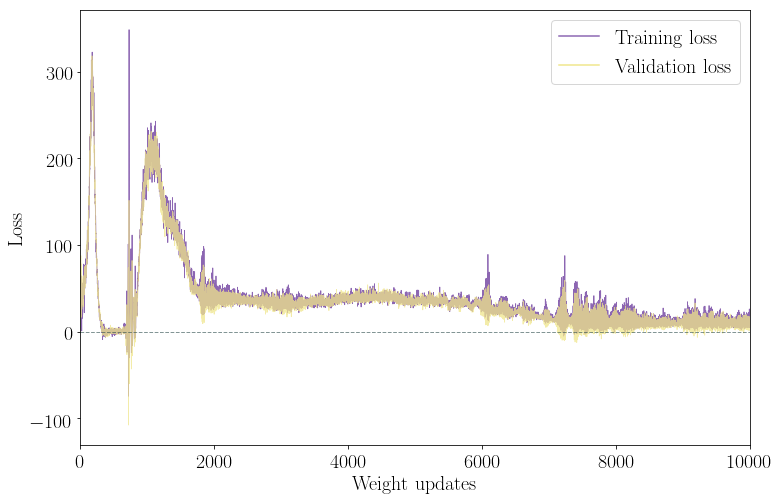

In [29]:
from matplotlib import rc
rc('text', usetex=True)

figure(figsize = (12, 8))
plot(np.arange(1, len(G_loss_training) + 1), G_loss_training, linewidth=0.8, linestyle='-', color='rebeccapurple', alpha=0.75)#, label=r'$\mathrm{Training \ loss}$')
plot(np.arange(1, len(G_loss_validation) + 1), G_loss_validation, linewidth=0.8, linestyle='-', color='khaki', alpha=0.75)#, label=r'$\mathrm{Validation \ loss}$')
#yscale('log')
axhline(y=0, linewidth=1, linestyle='--', color='darkslategrey', alpha=0.6)
axhline(y=10, xmin=0, xmax=0, linewidth=1.5, linestyle='-', color='rebeccapurple', alpha=0.75, label=r'$\mathrm{Training \ loss}$')
axhline(y=10, xmin=0, xmax=0, linewidth=1.5, linestyle='-', color='khaki', alpha=1.0, label=r'$\mathrm{Validation \ loss}$')
xlabel(r'$\mathrm{Weight \ updates}$', fontsize = 20)
ylabel(r'$\mathrm{Loss}$', fontsize = 20)
tick_params(labelsize = 20)
xlim([1, len(W_loss_training)]);
#xlim([0, 5*10**4]);
#ylim([-4, 4]);
legend(fontsize = 20);

### Predict the 3D halo distribution for any arbitrary simulation box size
The halo painting network can be used to predict the 3D halo distribution for any arbitrary simulation box size, such that a large simulation box does not require the tiling of smaller sub-elements. To do so, we must use a placeholder with the relevant size.

### Load test set

In [30]:
_ = sess.run(δ_assign, feed_dict={"initialise_density:0": np.load('../data_LPT_512/density_central_lpt_512.npy').reshape((resolution, resolution, resolution))})
_ = sess.run(h_assign, feed_dict={"initialise_halo:0": np.load('../data_LPT_512/halo_central_512_combined.npy').reshape((resolution, resolution, resolution))})

#### We must provide the indices of the 3D slice of interest

In [31]:
ind_1 = 100
ind_2 = 75
δ_slice = density[ind_1:big_slice_size + ind_1, 
                  ind_2:big_slice_size + ind_2, 
                  resolution - big_slice_size:]
test_δ = δ_slice[pad:big_slice_size - pad, 
                 pad:big_slice_size - pad, 
                 pad:big_slice_size - pad]
test_h = halo[ind_1 + pad:big_slice_size- pad + ind_1, 
              ind_2 + pad:big_slice_size - pad + ind_2, 
              resolution - big_slice_size + pad:-pad]

pred_h = sess.run(
    "G_com/big_output:0",
    feed_dict={
        "big_delta:0": δ_slice.reshape(
            (1, big_slice_size, big_slice_size, big_slice_size, 1))})[0, :, :, :, 0]

diff = test_h - pred_h

### Visualize a 3D slice (of given depth) of the predicted halo field
We also depict the input 2LPT density field and the corresponding reference halo counts for the given slice, and the difference between the predicted and true halo field. A visual comparison indicates qualitatively the efficacy of our halo painting network.

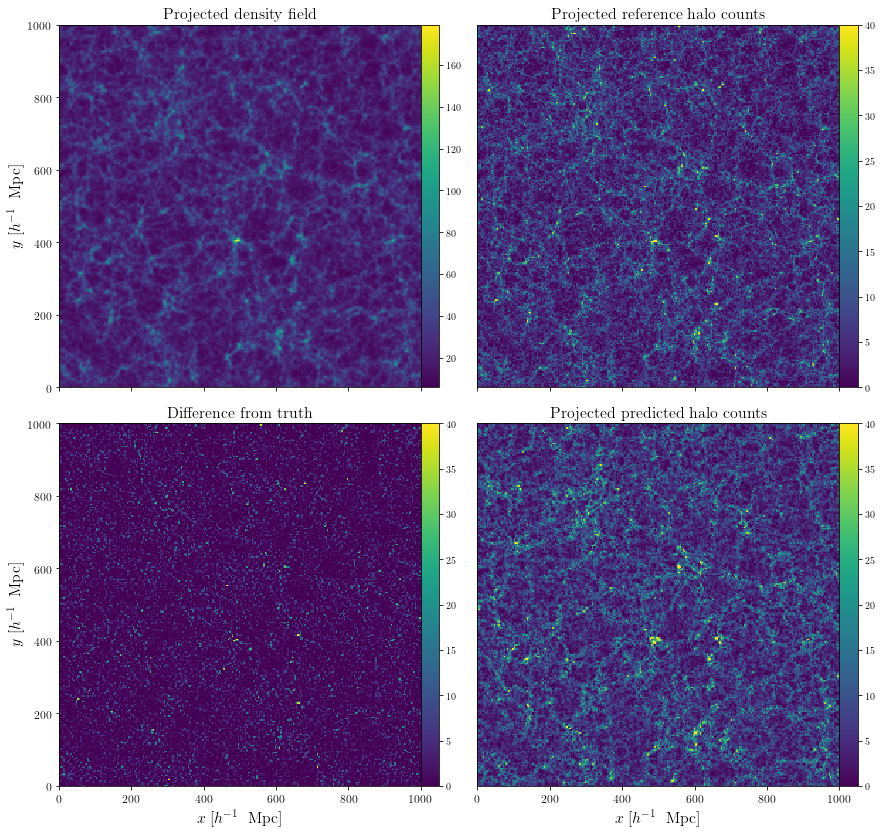

In [32]:
slice_num = 0
slice_thickness = 25

fig, ax = subplots(2, 2, figsize = (15,14)) # (14,14)
subplots_adjust(wspace = 0, hspace = 0.1) # 0.01

cmin = 0
cmax = 40

ax0 = ax[0,0].imshow(np.sum(test_δ[:,:,slice_num:slice_num+slice_thickness], 2), origin="lower", cmap="viridis", extent=[0, (2000./resolution)*big_size, 0, (2000./resolution)*big_size])
ax[0,0].set_title(r'$\mathrm{Projected \ density \ field}$', fontsize = 16);
ax[0,0].set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16);
ax[0,0].tick_params(axis='both', labelbottom=False, labelsize=12);
colorbar(ax0, ax = ax[0,0], fraction=0.0476, pad=0);

ax1 = ax[0,1].imshow(np.sum(test_h[:,:,slice_num:slice_num+slice_thickness], 2), origin="lower", cmap="viridis", extent=[0, (2000./resolution)*big_size, 0, (2000./resolution)*big_size], vmin=cmin, vmax=cmax)
ax[0,1].set_title(r'$\mathrm{Projected \ reference \ halo \ counts}$', fontsize = 16);
ax[0,1].set_yticks([]);
ax[0,1].tick_params(axis='both', labelbottom=False, labelsize=12);
colorbar(ax1, ax = ax[0,1], fraction=0.0476, pad=0);

ax2 = ax[1,1].imshow(np.sum(pred_h[:,:,slice_num:slice_num+slice_thickness], 2), origin="lower", cmap="viridis", extent=[0, (2000./resolution)*big_size, 0, (2000./resolution)*big_size], vmin=cmin, vmax=cmax)
ax[1,1].set_title(r'$\mathrm{Projected \ predicted \ halo \ counts}$', fontsize = 16);
ax[1,1].set_yticks([]);
ax[1,1].set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16); 
ax[1,1].tick_params(axis='both', labelsize=12);
colorbar(ax2, ax = ax[1,1], fraction=0.0476, pad=0);

ax3 = ax[1,0].imshow(np.sum(diff[:,:,slice_num:slice_num+slice_thickness], 2), origin="lower", cmap="viridis", extent=[0, (2000./resolution)*big_size, 0, (2000./resolution)*big_size], vmin=cmin, vmax=cmax)
ax[1,0].set_title(r'$\mathrm{Difference \ from \ truth}$', fontsize = 16);
ax[1,0].set_xlabel(r'$x \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16);
ax[1,0].set_ylabel(r'$y \; [h^{-1} \; \mathrm{\ Mpc}]$', fontsize = 16);
ax[1,0].tick_params(axis='both', labelsize=12);
colorbar(ax3, ax = ax[1,0], fraction=0.0476, pad=0);

### Compute 2-point summary statistics of reference and predicted halo fields

To quantitatively assess the efficacy of our mapping network, we can use summary statistics, as per the standard practice in cosmology. They provide a reliable metric to evaluate the network's capacity to encode essential information.

Assuming the cosmological density field is approximately a Gaussian random field, as is the case on the large scales or at earlier times, the 2-point statistics provide a sufficient description of the field. 

**Note**: We make `N_sims` number of predictions and represent the mean and $1\sigma$ confidence regions below.

In [ ]:
N_sims = 1000
Pk_δ_sims = []
Pk_h_sims = []
Pk_p_sims = []
r_c_sims = []
r_c_ref_sims = []
T_f_sims = []
s_sims = []
s_ref_sims = []

nbins = 80
lx = np.fft.fftfreq(int(big_size), d = 2000./resolution)[:, None, None] * 2. * np.pi
ly = np.fft.fftfreq(int(big_size), d = 2000./resolution)[None, :, None] * 2. * np.pi
lz = np.fft.fftfreq(int(big_size), d = 2000./resolution)[None, None, :int((big_size/2)+1)] * 2. * np.pi
l = np.sqrt(lx**2. + ly**2. + lz**2.)
P_w, l_bins = np.histogram(l, bins = nbins)
l_c = 0.5 * (l_bins[0:l_bins.size-1]+l_bins[1:])

def compute_single_cube_diagnostics(test_δ, test_h, pred_h):
    
    # Power spectrum (r_c) computations
    a_l_δ = np.fft.rfftn(test_δ)*(2000./resolution)**3.
    a_l_δ[0,0,0] = 0.
    C_l_δ = 1. / ( (2000./resolution)*big_size )**3. * np.absolute(a_l_δ)**2.

    a_l_h = np.fft.rfftn(test_h)*(2000./resolution)**3.
    a_l_h[0,0,0] = 0.
    C_l_h = 1. / ( (2000./resolution)*big_size )**3. * np.absolute(a_l_h)**2.
    
    a_l_p = np.fft.rfftn(pred_h)*(2000./resolution)**3.
    a_l_p[0,0,0] = 0.
    C_l_p = 1. / ( (2000./resolution)*big_size )**3. * np.absolute(a_l_p)**2.
    
    P_δ, l_bins = histogram(l, weights = C_l_δ, bins = nbins)
    P_h, l_bins = histogram(l, weights = C_l_h, bins = nbins)
    P_p, l_bins = histogram(l, weights = C_l_p, bins = nbins)
        
    P_δ /= P_w
    P_h /= P_w
    P_p /= P_w
    
    # Cross correlation coefficient (r_c) computations
    C_l_hp = 1. / ((2000./resolution)*big_size)**3. * ( np.real(a_l_h * a_l_p.conj()) )
    C_l_δh = 1. / ((2000./resolution)*big_size)**3. * ( np.real(a_l_δ * a_l_h.conj()) )
    C_l_δp = 1. / ((2000./resolution)*big_size)**3. * ( np.real(a_l_δ * a_l_p.conj()) )
    P_hp, l_bins = histogram(l, weights = C_l_hp, bins = nbins)
    P_hp /= P_w
    P_δh, l_bins = histogram(l, weights = C_l_δh, bins = nbins)
    P_δh /= P_w
    P_δp, l_bins = histogram(l, weights = C_l_δp, bins = nbins)
    P_δp /= P_w
    r_c = P_hp/(np.sqrt(P_h*P_p))
    r_c_ref = P_δh/(np.sqrt(P_δ*P_h))

    # Transfer function (T_f) computation
    T_f = np.sqrt(P_p/P_h)
    
    # Stochasticity (s) computation
    s = P_h*(1 - r_c**2)
    s_ref = P_h*(1 - r_c_ref**2)
    
    return P_δ, P_h, P_p, r_c, T_f, s, r_c_ref, s_ref

for i in tqdm.tqdm(range(N_sims)):
    
    ind_1 = np.random.randint(512 - (big_slice_size))
    ind_2 = np.random.randint(512 - (big_slice_size))
    ind_3 = np.random.randint(512 - (big_slice_size))
    δ_slice = density[ind_1:big_slice_size + ind_1, 
                      ind_2:big_slice_size + ind_2, 
                      ind_3:big_slice_size + ind_3] # 512 - big_slice_size:
    test_δ = δ_slice[pad:big_slice_size - pad, 
                     pad:big_slice_size - pad, 
                     pad:big_slice_size - pad]
    #test_δ_halo = 1 + (beta*test_δ)
    test_h = halo[ind_1 + pad:big_slice_size- pad + ind_1, 
                  ind_2 + pad:big_slice_size - pad + ind_2, 
                  resolution - big_slice_size + pad:-pad]
    
    pred_h = sess.run(
        "G_com/big_output:0",
        feed_dict={
            "big_delta:0": δ_slice.reshape(
                (1, big_slice_size, big_slice_size, big_slice_size, 1))})[0, :, :, :, 0]    

    P_δ_i, P_h_i, P_p_i, r_c_i, T_f_i, s_i, r_c_ref_i, s_ref_i = compute_single_cube_diagnostics(test_δ, test_h, pred_h)
    Pk_δ_sims.append(P_δ_i)
    Pk_h_sims.append(P_h_i)
    Pk_p_sims.append(P_p_i)
    r_c_sims.append(r_c_i)
    r_c_ref_sims.append(r_c_ref_i)
    T_f_sims.append(T_f_i)
    s_sims.append(s_i)
    s_ref_sims.append(s_ref_i)
    
# Compute summary diagnostics    
Pk_δ_mean = np.mean(Pk_δ_sims, axis = 0)
Pk_δ_std = np.std(Pk_δ_sims, axis = 0)
Pk_h_mean = np.mean(Pk_h_sims, axis = 0)
Pk_h_std = np.std(Pk_h_sims, axis = 0)
Pk_p_mean = np.mean(Pk_p_sims, axis = 0)
Pk_p_std = np.std(Pk_p_sims, axis = 0)

T_f_mean = np.mean(T_f_sims, axis = 0)
T_f_std = np.std(T_f_sims, axis = 0)

r_c_mean = np.mean(r_c_sims, axis = 0)
r_c_std = np.std(r_c_sims, axis = 0)

s_mean = np.mean(s_sims, axis = 0)
s_std = np.std(s_sims, axis = 0)

s_ref_mean = np.mean(s_ref_sims, axis = 0)
s_ref_std = np.std(s_ref_sims, axis = 0)

r_c_ref_mean = np.mean(r_c_ref_sims, axis = 0)
r_c_ref_std = np.std(r_c_ref_sims, axis = 0)

#### Power spectrum

We first consider the power spectra of the reference and predicted halo distributions. We find that the power spectrum of the predicted halo field match extremely closely that of the reference halo distribution. This quantitatively showcases the remarkable performance of our halo painting network.

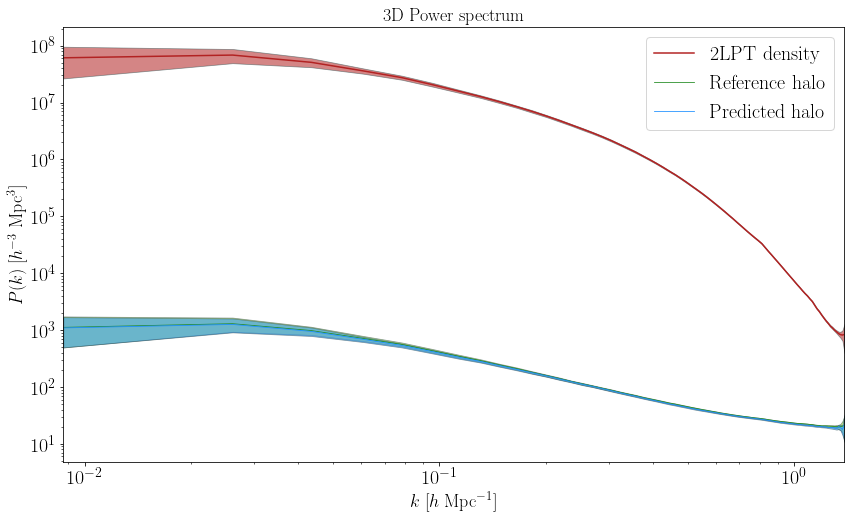

In [34]:
figure(figsize = (14, 8))

plot(l_c, Pk_δ_mean, color='firebrick', label=r'$\mathrm{2LPT \ density}$')
fill_between(l_c, Pk_δ_mean - Pk_δ_std, Pk_δ_mean + Pk_δ_std, facecolor="firebrick", edgecolor="darkslategrey", lw=0.75, alpha=0.55)
plot(l_c, Pk_h_mean, linewidth=0.8, linestyle='-', color='forestgreen', alpha=1.0, label=r'$\mathrm{Reference \ halo}$');
fill_between(l_c, Pk_h_mean - Pk_h_std, Pk_h_mean + Pk_h_std, facecolor="yellowgreen", edgecolor="darkslategrey", lw=0.75, alpha=0.55)
plot(l_c, Pk_p_mean, linewidth=0.8, linestyle='-', color='dodgerblue', alpha=1.0, label=r'$\mathrm{Predicted \ halo}$');
fill_between(l_c, Pk_p_mean - Pk_p_std, Pk_p_mean + Pk_p_std, facecolor="dodgerblue", edgecolor="darkslategrey", lw=0.75, alpha=0.55)

xscale('log')
yscale('log')
title(r'$\mathrm{3D \ Power \ spectrum}$', fontsize = 18)
xlabel(r'$k \; [h \; {\mathrm{Mpc}}^{-1}]$', fontsize = 18)
ylabel(r'$P(k) \; [h^{-3} \; {\mathrm{Mpc}}^{3}]$', fontsize = 18)
xlim([np.min(l_c), np.max(l_c)])
tick_params(labelsize = 20)
legend(fontsize = 20);

#### Cross-correlation coefficient

This diagnostic characterizes the mismatch in phases between the real and predicted halo count fields. The behaviour of this cross-correlation coefficient below demonstrates the predictive capability of our network. Note that the turnover in the cross-correlation coefficient is due to the grid resolution, and the prediction in the shaded area is not taken into account in practice. We find that our network reproduces the reference halo field with overall higher fidelity than 2LPT.

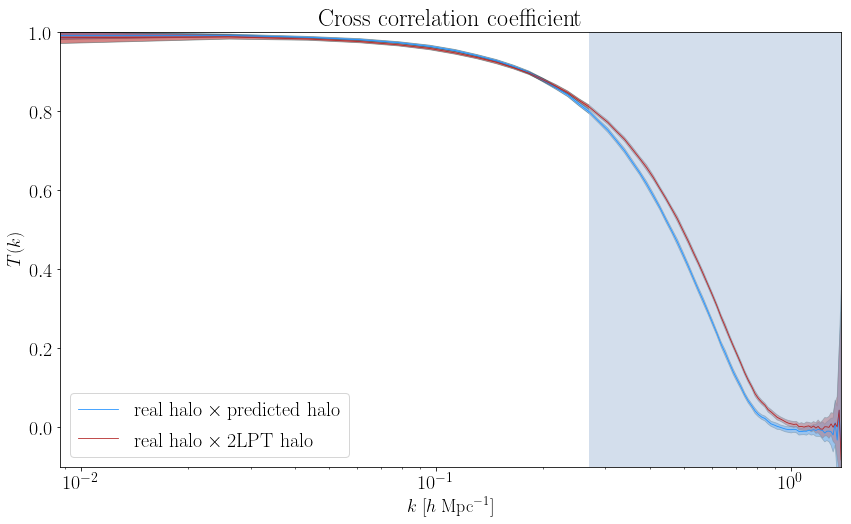

In [35]:
figure(figsize = (14, 8))

plot(l_c, r_c_mean, linewidth=0.8, linestyle='-', color='dodgerblue', alpha=1.0, label=r'$\mathrm{real \ halo}\times\mathrm{predicted \ halo}$');
fill_between(l_c, r_c_mean - r_c_std, r_c_mean + r_c_std, facecolor="dodgerblue", edgecolor="darkslategrey", lw=0.75, alpha=0.55)
plot(l_c, r_c_ref_mean, linewidth=0.8, linestyle='-', color='firebrick', alpha=1.0, label=r'$\mathrm{real \ halo}\times\mathrm{2LPT \ halo}$');
fill_between(l_c, r_c_ref_mean - r_c_ref_std, r_c_ref_mean + r_c_ref_std, facecolor="firebrick", edgecolor="darkslategrey", lw=0.75, alpha=0.55)

fill_between(l_c, -10, 70, where=l_c >= 0.256, facecolor="lightsteelblue", alpha=0.55)
xscale('log')
title(r'$\mathrm{Cross \ correlation \ coefficient}$', fontsize = 24);
xlabel(r'$k \; [h \; {\mathrm{Mpc}}^{-1}]$', fontsize = 18);
ylabel(r'$T(k)$', fontsize = 18);
xlim(l_c[0],l_c[-1])
ylim([-0.1, 1e0])
tick_params(labelsize = 20)
legend(fontsize = 20, loc=3);

#### Stochasticity

The stochasticity encodes the fraction of the variance that cannot be accounted for in the true model. As with the cross-correlation coefficient, this shows the predictive power of our network.

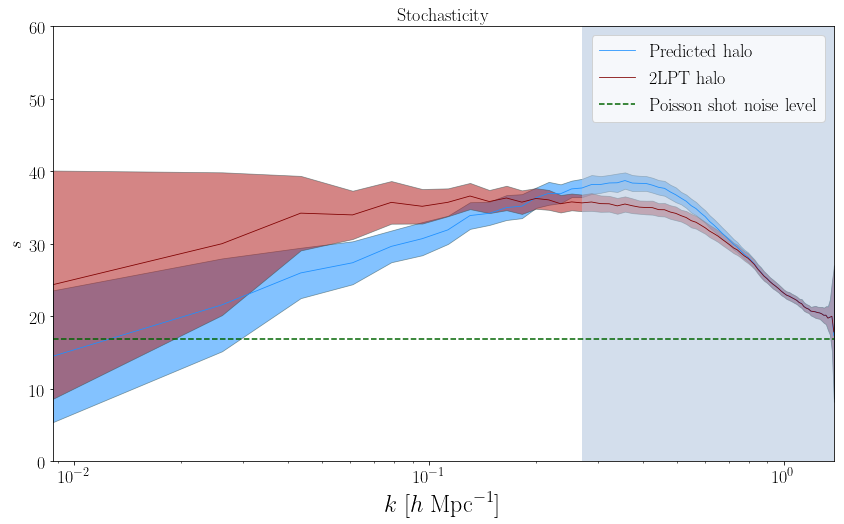

In [36]:
L=(2000./resolution)*big_size
P_poisson = (L/big_size)**3*(pred_h.sum()/big_size**3)

figure(figsize = (14, 8))

plot(l_c, s_mean, linewidth=0.8, linestyle='-', color='dodgerblue', alpha=1.0, label=r'$\mathrm{Predicted \ halo}$');
fill_between(l_c, s_mean - s_std, s_mean + s_std, facecolor="dodgerblue", edgecolor="darkslategrey", lw=0.75, alpha=0.55);
plot(l_c, s_ref_mean, linewidth=0.8, linestyle='-', color='maroon', alpha=1.0, label=r'$\mathrm{2LPT \ halo}$');
fill_between(l_c, s_ref_mean - s_ref_std, s_ref_mean + s_ref_std, facecolor="firebrick", edgecolor="darkslategrey", lw=0.75, alpha=0.55)

fill_between(l_c, -10, 70, where=l_c >= 0.256, facecolor="lightsteelblue", alpha=0.55)
axhline(y=P_poisson, linewidth=1.5, linestyle='--', color='darkgreen', alpha=1.0, label=r'$\mathrm{Poisson \ shot \ noise \ level}$')
xscale('log')
title(r'$\mathrm{Stochasticity}$', fontsize = 18);
xlabel(r'$k \; [h \; {\mathrm{Mpc}}^{-1}]$', fontsize = 24);
ylabel(r'$s$', fontsize = 18);
ylim(0, 60)
xlim(l_c[0],l_c[-1])
tick_params(labelsize = 18)
legend(fontsize = 18);

#### Transfer function

Defined as the square root of the ratio of the predicted to reference auto power spectra, the transfer function indicates the discrepancy in amplitudes, as function of Fourier modes. The plot below shows the agreement between our network prediction and the reference halo distribution.

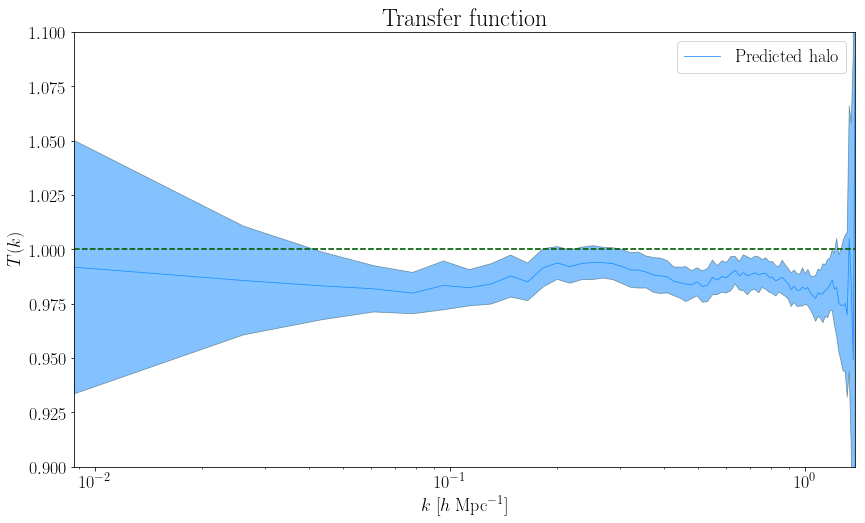

In [37]:
figure(figsize = (14, 8))

plot(l_c, T_f_mean, linewidth=0.8, linestyle='-', color='dodgerblue', alpha=1.0, label=r'$\mathrm{Predicted \ halo}$');
fill_between(l_c, T_f_mean - T_f_std, T_f_mean + T_f_std, facecolor="dodgerblue", edgecolor="darkslategrey", lw=0.75, alpha=0.55)

axhline(y=1., linewidth=1.5, linestyle='--', color='darkslategrey', alpha=0.6)
xscale("log")
ylim(0.9, 1.1)
title(r'$\mathrm{Transfer \ function}$', fontsize = 24);
xlabel(r'$k \; [h \; {\mathrm{Mpc}}^{-1}]$', fontsize = 18);
ylabel(r'$T(k)$', fontsize = 18);
xlim(l_c[0],l_c[-1])
axhline(y=1., linewidth=1.5, linestyle='--', color='darkgreen', alpha=1.0)
tick_params(labelsize = 18)
legend(fontsize = 18);

#### Note:

1) The bispectrum computations for their relevant plots in the paper are done using a publicly available code [Pylians](https://github.com/franciscovillaescusa/Pylians).

2) The plots for the different cosmologies simply require making predictions of the trained model for different sets of input 2LPT and corresponding halo fields;

```python
_ = sess.run(δ_assign, feed_dict={"initialise_density:0": np.load('../data_LPT_omega_plus_512/density_omegam_plus_lpt_512.npy').reshape((resolution, resolution, resolution))})
_ = sess.run(h_assign, feed_dict={"initialise_halo:0": np.load('../data_LPT_512/halo_omegam_plus_512.npy').reshape((resolution, resolution, resolution))})```